## calculer stand et bike en lier some=stand +bike

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

file_path = 'bike_55.csv'
data = pd.read_csv(file_path)

data['timestamp'] = pd.to_datetime(data['timestamp'], format='mixed', errors='coerce')
data['hour'] = data['timestamp'].dt.hour
data['day_of_week'] = data['timestamp'].dt.dayofweek  # Monday=0, Sunday=6
features = data[['hour', 'day_of_week', 'number']].values
targets = data['available_bikes'].values  


scaler_features = StandardScaler()
features_scaled = scaler_features.fit_transform(features)

scaler_targets = StandardScaler()
targets_scaled = scaler_targets.fit_transform(targets.reshape(-1, 1))


X_train, X_test, y_train, y_test = train_test_split(features_scaled, targets_scaled, test_size=0.2, random_state=42)


model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')  
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

print("Training the model...")
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, verbose=1)

y_pred_scaled = model.predict(X_test)

y_pred = scaler_targets.inverse_transform(y_pred_scaled)
y_test_original = scaler_targets.inverse_transform(y_test)

total_bike_stands = data['available_bike_stands'] + data['available_bikes']  
total_bike_stands = total_bike_stands.iloc[0]  
y_pred_stands = total_bike_stands - y_pred  
y_test_stands = total_bike_stands - y_test_original




Training the model...
Epoch 1/20
55/55 [==============================] - 6s 39ms/step - loss: 0.8705 - mae: 0.7422 - val_loss: 1.0149 - val_mae: 0.7898
Epoch 2/20
55/55 [==============================] - 1s 19ms/step - loss: 0.8292 - mae: 0.7104 - val_loss: 0.9892 - val_mae: 0.7875
Epoch 3/20
55/55 [==============================] - 1s 11ms/step - loss: 0.8091 - mae: 0.7053 - val_loss: 0.9706 - val_mae: 0.7651
Epoch 4/20
55/55 [==============================] - 1s 11ms/step - loss: 0.7902 - mae: 0.6942 - val_loss: 0.9435 - val_mae: 0.7697
Epoch 5/20
55/55 [==============================] - 1s 17ms/step - loss: 0.7780 - mae: 0.6935 - val_loss: 0.9404 - val_mae: 0.7866
Epoch 6/20
55/55 [==============================] - 1s 12ms/step - loss: 0.7608 - mae: 0.6850 - val_loss: 0.9147 - val_mae: 0.7927
Epoch 7/20
55/55 [==============================] - 1s 10ms/step - loss: 0.7674 - mae: 0.6995 - val_loss: 0.9325 - val_mae: 0.7467
Epoch 8/20
55/55 [==============================] - 1s 16ms/s

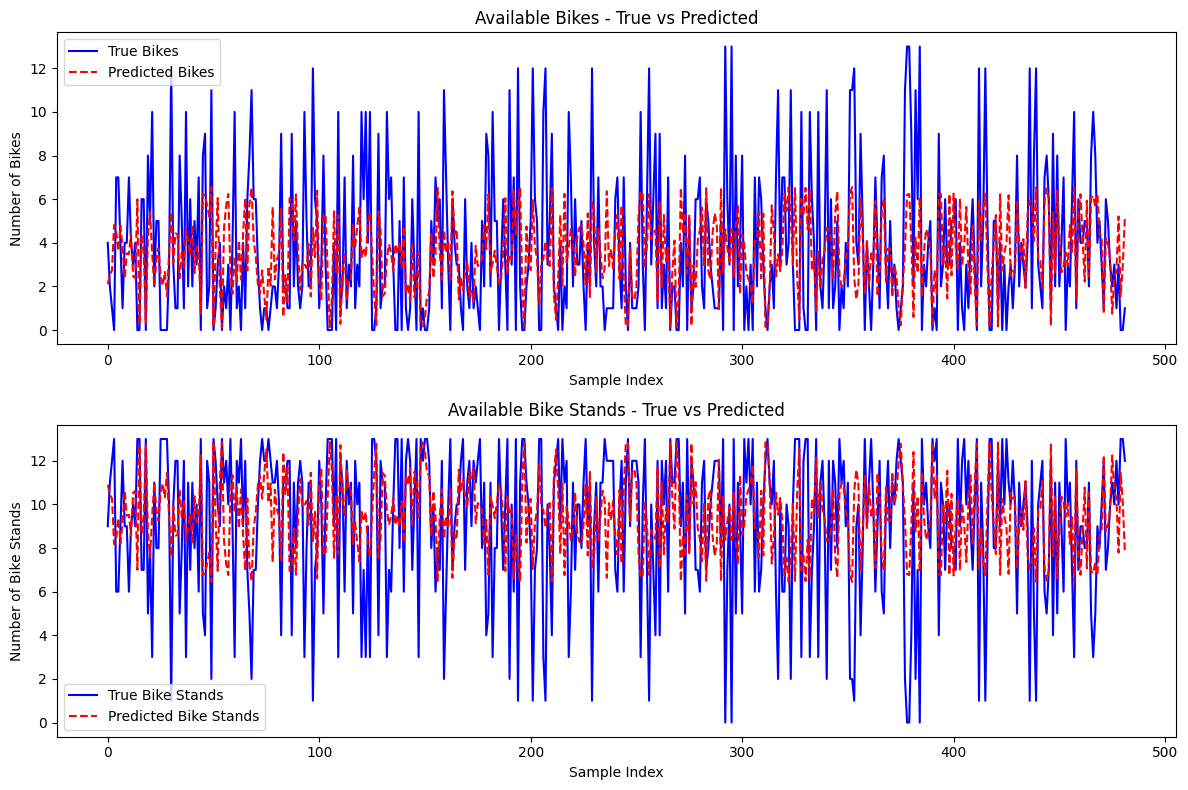

In [2]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(y_test_original, label='True Bikes', color='blue')
plt.plot(y_pred, label='Predicted Bikes', linestyle='--', color='red')
plt.title('Available Bikes - True vs Predicted')
plt.xlabel('Sample Index')
plt.ylabel('Number of Bikes')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(y_test_stands, label='True Bike Stands', color='blue')
plt.plot(y_pred_stands, label='Predicted Bike Stands', linestyle='--', color='red')
plt.title('Available Bike Stands - True vs Predicted')
plt.xlabel('Sample Index')
plt.ylabel('Number of Bike Stands')
plt.legend()

plt.tight_layout()
plt.show()

## training independant de stand et bike

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

file_path = 'bike_55.csv'
data = pd.read_csv(file_path)

data['timestamp'] = pd.to_datetime(data['timestamp'], format='mixed', errors='coerce')
data['hour'] = data['timestamp'].dt.hour
data['day_of_week'] = data['timestamp'].dt.dayofweek  # Monday=0, Sunday=6
features = data[['hour', 'day_of_week', 'number']].values
targets = np.column_stack((data['available_bike_stands'].values, data['available_bikes'].values))

scaler_features = StandardScaler()
features_scaled = scaler_features.fit_transform(features)

scaler_targets = StandardScaler()
targets_scaled = scaler_targets.fit_transform(targets)

X_train, X_test, y_train, y_test = train_test_split(features_scaled, targets_scaled, test_size=0.2, random_state=42)

input_layer = Input(shape=(X_train.shape[1],))

shared_layer = Dense(128, activation='relu')(input_layer)
shared_layer = Dense(64, activation='relu')(shared_layer)

output_stands = Dense(32, activation='relu')(shared_layer)
output_stands = Dense(1, activation='linear', name='bike_stands')(output_stands)

output_bikes = Dense(32, activation='relu')(shared_layer)
output_bikes = Dense(1, activation='linear', name='bikes')(output_bikes)

model = Model(inputs=input_layer, outputs=[output_stands, output_bikes])

model.compile(optimizer='adam',
              loss={'bike_stands': 'mse', 'bikes': 'mse'},
              metrics={'bike_stands': 'mae', 'bikes': 'mae'})


print("Training the model...")
history = model.fit(X_train,
                    {'bike_stands': y_train[:, 0], 'bikes': y_train[:, 1]},
                    epochs=20,
                    batch_size=32,
                    validation_split=0.1,
                    verbose=1)

y_pred_stands, y_pred_bikes = model.predict(X_test)

y_pred_stands_original = scaler_targets.inverse_transform(
    np.column_stack((y_pred_stands, np.zeros_like(y_pred_stands))))[:, 0]
y_pred_bikes_original = scaler_targets.inverse_transform(
    np.column_stack((np.zeros_like(y_pred_bikes), y_pred_bikes)))[:, 1]




Training the model...
Epoch 1/20
55/55 [==============================] - 14s 62ms/step - loss: 1.7774 - bike_stands_loss: 0.8923 - bikes_loss: 0.8851 - bike_stands_mae: 0.7668 - bikes_mae: 0.7574 - val_loss: 2.0637 - val_bike_stands_loss: 1.0517 - val_bikes_loss: 1.0120 - val_bike_stands_mae: 0.8227 - val_bikes_mae: 0.8025
Epoch 2/20
55/55 [==============================] - 1s 18ms/step - loss: 1.6671 - bike_stands_loss: 0.8383 - bikes_loss: 0.8287 - bike_stands_mae: 0.7299 - bikes_mae: 0.7126 - val_loss: 2.0263 - val_bike_stands_loss: 1.0293 - val_bikes_loss: 0.9970 - val_bike_stands_mae: 0.8060 - val_bikes_mae: 0.7841
Epoch 3/20
55/55 [==============================] - 1s 19ms/step - loss: 1.6331 - bike_stands_loss: 0.8177 - bikes_loss: 0.8154 - bike_stands_mae: 0.7239 - bikes_mae: 0.7085 - val_loss: 1.9821 - val_bike_stands_loss: 1.0100 - val_bikes_loss: 0.9721 - val_bike_stands_mae: 0.8115 - val_bikes_mae: 0.7854
Epoch 4/20
55/55 [==============================] - 1s 18ms/step - l

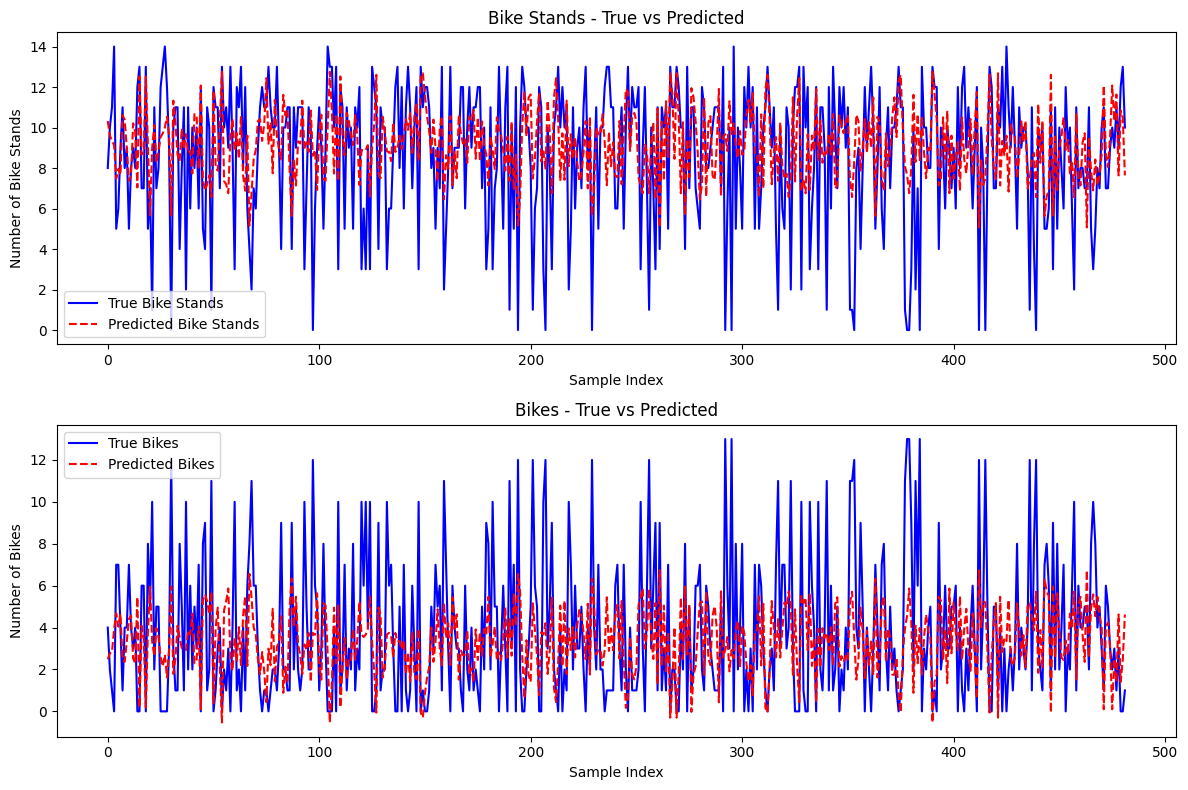

In [4]:

plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(scaler_targets.inverse_transform(y_test)[:, 0], label='True Bike Stands', color='blue')
plt.plot(y_pred_stands_original, label='Predicted Bike Stands', linestyle='--', color='red')
plt.title('Bike Stands - True vs Predicted')
plt.xlabel('Sample Index')
plt.ylabel('Number of Bike Stands')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(scaler_targets.inverse_transform(y_test)[:, 1], label='True Bikes', color='blue')
plt.plot(y_pred_bikes_original, label='Predicted Bikes', linestyle='--', color='red')
plt.title('Bikes - True vs Predicted')
plt.xlabel('Sample Index')
plt.ylabel('Number of Bikes')
plt.legend()

plt.tight_layout()
plt.show()